# Импорты

In [ ]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import imageio
from osgeo import gdal
from pyproj import Proj, transform
from pyproj import CRS
import cv2
import pandas as pd

# Отображение снимка

In [ ]:
# Путь к файлу формата TIFF
tiff_file = 'имя файла.tiff'
# Открытие файла TIFF с помощью библиотеки rasterio
with rasterio.open(tiff_file) as src:
    # Чтение каналов изображения (RGB)
    r = src.read(1)
    g = src.read(2)
    b = src.read(3)
    alpha = src.read(4)  # Чтение альфа-канала

    rgb_image = np.dstack((r, g, b))

    # Установка прозрачности фона на основе альфа-канала
    rgb_image_with_alpha = np.dstack((rgb_image, alpha))

    plt.imshow(rgb_image_with_alpha)
    plt.axis('off')
    plt.show()

# Загрузка необходимых файлов и извлечение бэндов (Landsat)

Здесь происходит замена символов в имени файла и добавление новых файлов в словарь, чтобы не делать это вручную.     
Например, есть файл '/content/drive/MyDrive/Угра/угра ландсат 4-5 ТМ (1990-2011)/1990-08-09/EO_Browser_images (69).zip (Unzipped Files)/1990-08-09-00:00_1990-08-09-23:59_Landsat_4-5_TM_L2_True_color.tiff'.    
Тут заменяется "True color" на номер бэндов: '/content/drive/MyDrive/Угра/угра ландсат 4-5 ТМ (1990-2011)/1990-08-09/EO_Browser_images (69).zip (Unzipped Files)/1990-08-09-00:00_1990-08-09-23:59_Landsat_4-5_TM_L2_B02_(Raw).tiff' и так далее.

In [ ]:
# Автоматическая замена бэндов и загрузка файлов
tiff_file = '/content/drive/MyDrive/Угра/угра ландсат 4-5 ТМ (1990-2011)/1990-08-09/EO_Browser_images (69).zip (Unzipped Files)/1990-08-09-00:00_1990-08-09-23:59_Landsat_4-5_TM_L2_True_color.tiff'
bands = ['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07']

tiff_files = {}

for i in range(len(bands)):
    band_number = bands[i]
    if 'Landsat_8-9' in tiff_file:
        if i == 0:
            continue
        band_number = f"{bands[i][:-1]}{int(bands[i][-1]) - 1}"
    tiff_files[f"{band_number}"] = tiff_file.replace('True_color', f'{band_number}_(Raw)')

In [ ]:
bands_values =  {}
# Извлечение бэндов и открытие файлов
for k, v in tiff_files.items():
    with rasterio.open(v) as src:
        scr = Proj(CRS.from_epsg(4326))
        band = src.read(1)
        bands_values[k] = band

# Расчёт индексов на основе снимка (Landsat)

In [ ]:
if not 'Landsat_8-9' in tiff_file:
    # для 4-5, 7
    # Расчет NDVI
    NDVI = (bands_values['B04'] - bands_values['B03']) / (bands_values['B04'] + bands_values['B03'])  # для 4-5

    # Расчет GNDVI
    GNDVI = (bands_values['B04'] - bands_values['B02']) / (bands_values['B03'] + bands_values['B02'])

    # Расчет DVI
    DVI = bands_values['B04'] - bands_values['B03']

    # Расчет OSAVI
    OSAVI = 1.16 * (bands_values['B04'] - bands_values['B03']) / (bands_values['B04'] + bands_values['B03'] + 0.16)

    # Расчет ExG
    ExG = (2 * bands_values['B02'] - bands_values['B03'] - bands_values['B01']) / (bands_values['B01'] + bands_values['B02'] + bands_values['B03'])

    # Расчет ExR
    ExR = (1.4 * bands_values['B03'] - bands_values['B02']) / (bands_values['B01'] + bands_values['B02'] + bands_values['B03'])

    # Расчет ExG_subtract_ExR
    ExG_subtract_ExR = ExG - ExR

    # Расчет NDI
    NDI = (bands_values['B02'] - bands_values['B03']) / (bands_values['B02'] + bands_values['B03'])

    # Расчет NDRE
    # NDRE = (bands_values['B08'] - bands_values['B06']) / (bands_values['B08'] + bands_values['B06'])

    # Расчет EVI
    EVI = 2.5 * (bands_values['B04'] - bands_values['B03']) / (bands_values['B04'] + 6 * bands_values['B03'] - 7.5 * bands_values['B01'] + 1)
else:
    # для 8-9
    NDVI = (bands_values['B05'] - bands_values['B04']) / (bands_values['B05'] + bands_values['B04'])
    GNDVI = (bands_values['B05'] - bands_values['B03']) / (bands_values['B04'] + bands_values['B03'])
    DVI = bands_values['B05'] - bands_values['B04']
    OSAVI = 1.16 * (bands_values['B05'] - bands_values['B04']) / (bands_values['B05'] + bands_values['B04'] + 0.16)
    ExG = (2 * bands_values['B03'] - bands_values['B04'] - bands_values['B02']) / (bands_values['B02'] + bands_values['B03'] + bands_values['B04'])
    ExR = (1.4 * bands_values['B04'] - bands_values['B03']) / (bands_values['B02'] + bands_values['B03'] + bands_values['B04'])
    ExG_subtract_ExR = ExG - ExR
    NDI = (bands_values['B03'] - bands_values['B04']) / (bands_values['B03'] + bands_values['B04'])
    EVI = 2.5 * (bands_values['B05'] - bands_values['B04']) / (bands_values['B05'] + 6 * bands_values['B04'] - 7.5 * bands_values['B02'] + 1)

Далее указываем какой индекс нужен и заменяем пустые значения из снимкаа на "2" (обычно это нужно если снимок имеет не прямоугольную форму)

In [ ]:
index = NDVI
index_name = 'NDVI'

mean_value = np.nanmean(index)
print(mean_value)
fil_index = index[~np.isnan(index)]
print(np.nanmean(fil_index))

fil_index = np.nan_to_num(index, nan=2)
print(fil_index.mean())

# Загрузка необходимых файлов и извлечение бэндов (Sentinel 2)

Здесь всё тоже самое, что и с ландсатом.

In [ ]:
# Автоматическая замена бэндов и загрузка файлов
tiff_file = '/content/drive/MyDrive/Угра/для презы/EO_Browser_images (76).zip (Unzipped Files)/2021-06-04-00:00_2021-06-04-23:59_Sentinel-2_L2A_True_color.tiff'

bands = ['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B09', 'B11', 'B12']

tiff_files = {}

for i in range(12):
    band_number = bands[i]
    tiff_files[f"{band_number}"] = tiff_file.replace('True_color', f'{band_number}_(Raw)')

In [ ]:
bands_values =  {}
# Извлечение бэндов и открытие файлов
for k, v in tiff_files.items():
    with rasterio.open(v) as src:
        scr = Proj(CRS.from_epsg(4326))
        band = src.read(1)
        bands_values[k] = band

# Расчёт индексов на основе снимка (Sentinel 2)

In [ ]:
# Расчет NDVI
NDVI = (bands_values['B08'] - bands_values['B04']) / (bands_values['B08'] + bands_values['B04'])

# Расчет GNDVI
GNDVI = (bands_values['B08'] - bands_values['B03']) / (bands_values['B08'] + bands_values['B03'])

# Расчет DVI
DVI = bands_values['B08'] - bands_values['B04']

# Расчет OSAVI
OSAVI = 1.16 * (bands_values['B08'] - bands_values['B04']) / (bands_values['B08'] + bands_values['B04'] + 0.16)

# Расчет ExG
ExG = (2 * bands_values['B03'] - bands_values['B04'] - bands_values['B02']) / (bands_values['B02'] + bands_values['B03'] + bands_values['B04'])

# Расчет ExR
ExR = (1.4 * bands_values['B04'] - bands_values['B03']) / (bands_values['B02'] + bands_values['B03'] + bands_values['B04'])

# Расчет ExG_subtract_ExR
ExG_subtract_ExR = ExG - ExR

# Расчет NDI
NDI = (bands_values['B03'] - bands_values['B04']) / (bands_values['B03'] + bands_values['B04'])

# Расчет NDRE
NDRE = (bands_values['B08'] - bands_values['B06']) / (bands_values['B08'] + bands_values['B06'])

# Расчет EVI
EVI = 2.5 * (bands_values['B08'] - bands_values['B04']) / (bands_values['B08'] + 6 * bands_values['B04'] - 7.5 * bands_values['B02'] + 1)

In [ ]:
index = NDVI
index_name = 'NDVI'

mean_value = np.nanmean(index)
print(mean_value)
fil_index = index[~np.isnan(index)]
print(np.nanmean(fil_index))

fil_index = np.nan_to_num(index, nan=2)
print(fil_index.mean())

In [ ]:
print(pd.DataFrame(NDVI))

# Извлечение координат из файла tiff

Если координаты не нужны, то запускать эту ячейку не нужно.

In [ ]:
def get_geographic_coordinates(tiff_file):
    dataset = gdal.Open(tiff_file)

    # Получаем геотрансформацию
    geotransform = dataset.GetGeoTransform()

    # Извлекаем географические координаты
    up_l_x = geotransform[0]
    up_l_y = geotransform[3]

    lo_r_x = up_l_x + geotransform[1] * dataset.RasterXSize
    lo_r_y = up_l_y + geotransform[5] * dataset.RasterYSize

    up_r_x = up_l_x + geotransform[1] * dataset.RasterXSize
    up_r_y = geotransform[3]

    lo_l_x = geotransform[0]
    lo_l_y = up_l_y + geotransform[5] * dataset.RasterYSize

    # Преобразуем координаты в географические
    in_proj = Proj(init='epsg:3857')  # Проекция данных в файле (Web Mercator)
    out_proj = Proj(init='epsg:4326')  # Географическая проекция (WGS84)

    ul_lng, ul_lat = transform(in_proj, out_proj, up_l_x, up_l_y)
    lr_lng, lr_lat = transform(in_proj, out_proj, lo_r_x, lo_r_y)
    ur_lng, ur_lat = transform(in_proj, out_proj, up_r_x, up_r_y)
    ll_lng, ll_lat = transform(in_proj, out_proj, lo_l_x, lo_l_y)

    return (ul_lng, ul_lat, lr_lng, lr_lat, ur_lng, ur_lat, ll_lng, ll_lat)

# Приминяем функцию
coordinates = get_geographic_coordinates(tiff_file)
angels = np.array([[coordinates[0], coordinates[1], coordinates[4], coordinates[5]], [coordinates[6], coordinates[7], coordinates[2], coordinates[3]]])

print(f'lng, lat \n{angels}')

# Соотношение значений индексов с полученными данными

NDVI: май - 0.81, июнь - 0.845, июль - 0.85, август - 0.86, сентярбь - 0,66.

GNDVI: май - 0.669, июнь - 0.725, июль - 0.75, август - 0.76, сентярбь - 0.665.

DVI: май - 0.26, июнь - 0.33, июль - 0.32, август - 0.27, сентярбь - 0.17.

NDRE: май - 0.089, июнь - 0.08, июль - 0.095, август - 0.09, сентярбь - 0.079.

EVI: май - 0.505, июнь - 0.63, июль - 0.61, август - 0.55, сентябрь - 0.33.
    
    
Снимки за май, сентябрь лучше не использовать. А также лучше не брать снимки за конец июня - середину июля.

In [ ]:
# Заданный словарь с данными
index_limit = {'NDVI': 0.8, 'GNDVI': 0.665, 'DVI': 0.17, 'OSAVI': 0.71, 'NDRE': 0.089, 'EVI': 0.55}

# Функция для замены данных в переменной fil_ndvi в соответствии с условиями
def replace_data(fil_index, input_data, index_name):
    for i in range(fil_index.shape[0]):
        for j in range(fil_index.shape[1]):
            if fil_index[i][j] == None:
              print(1)
            if index_limit[index_name] <= fil_index[i][j] <= 1:
              fil_index[i][j] = 1
            elif 0 <= fil_index[i][j] < index_limit[index_name]:
              fil_index[i][j] = 0
            else:
              fil_index[i][j] = 2
    return fil_index
# Применяем функцию к данным
tf_matrix = replace_data(fil_index, index_limit, index_name)
print(pd.DataFrame(tf_matrix))

Следующие две ячейки нужны если нужно получить картинкку, где будет показано в каких местах деревья исчезли / появились.    
Для начала нужно запустить необходимые ячейки выше и следующую ячейку после этой (с martrix_1), затем с новым снимком запустить те же ячейки выше и ячейку с matrix_2.    
Если сравнение не нужно, то запускать ячейки не надо.

In [ ]:
# Для сравнения двух цветовых схем
matrix_1 = tf_matrix # matrix_1990

In [ ]:
# Для сравнения двух цветовых схем
matrix_2 = tf_matrix # matrix_2023

# Создание цветовой схемы по полученной матрице

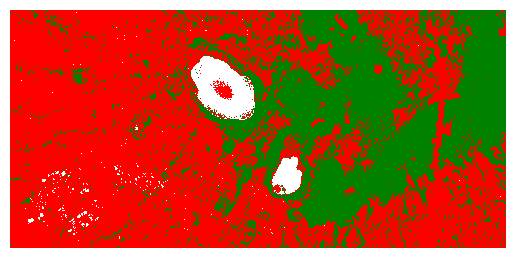

<ipython-input-35-ad33731410d9>:15: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(tiff_file)


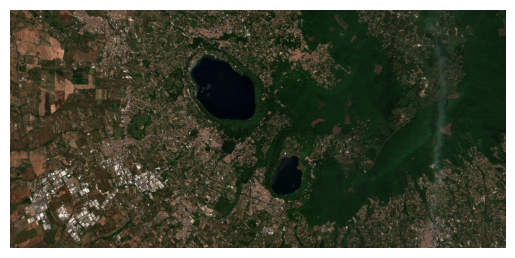

In [ ]:
# Определение цветов для каждого значения в матрице
colors = {0: 'red', 1: 'green', 2: 'white', 3: 'black'}

# Составление цветовой карты
color_map = np.vectorize(colors.get)(tf_matrix)

# Преобразование строковых цветов в числовой формат RGBA
color_map_rgba = np.array([[mcolors.to_rgba(color) for color in row] for row in color_map])

plt.imshow(color_map_rgba, interpolation='nearest')
plt.axis('off')
plt.show()

# Исходное изображение0
image = imageio.imread(tiff_file)
plt.imshow(image)
plt.axis('off')
plt.show()

In [ ]:
# Подсчет количества красных и зеленых пикселей
red_pixels = np.sum(color_map == 'red')
green_pixels = np.sum(color_map == 'green')

# Подсчет общего количества пикселей
total_pixels = red_pixels + green_pixels

# Подсчет процента зеленых пикселей
green_percentage = (green_pixels / total_pixels) * 100

print(f'Количество красных пикселей: {red_pixels}')
print(f'Количество зеленых пикселей: {green_pixels}')
print(f'Процент зеленых пикселей на фото: {green_percentage:.2f}%')

Количество красных пикселей: 141454
Количество зеленых пикселей: 222747
Процент зеленых пикселей на фото: 61.16%


# Построение временных рядов


Значения NDVI

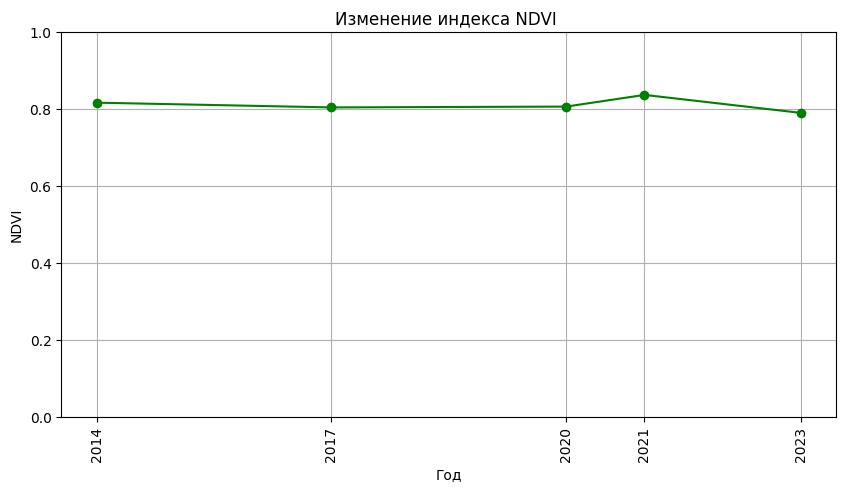

In [ ]:
# Данные в виде словаря {год: значение NDVI}
data = {1990: 0.718064149022841, 1995: 0.730552115352918, 1999: 0.769304808085156, 2005: 0.791610406, 2010: 0.792996198, 2014: 0.8154279, 2017: 0.80308515, 2020: 0.80521223, 2021: 0.8355773, 2023: 0.788815777}

# Преобразуем данные в DataFrame
df = pd.DataFrame(list(data.items()), columns=['Year', 'NDVI'])

# Создаем график
plt.figure(figsize=(10, 5))
plt.plot(df['Year'], df['NDVI'], marker='o', color='g', linestyle='-')

# Настройки осей
plt.xlabel('Год')
plt.ylabel('NDVI')
plt.title('Изменение индекса NDVI ')
plt.xticks(df['Year'], rotation=90)

# Устанавливаем минимальное и максимальное значение для оси Y
plt.ylim(0, 1)

# Отображаем график
plt.grid(True)
plt.show()

Процент "зелёных" пикселей

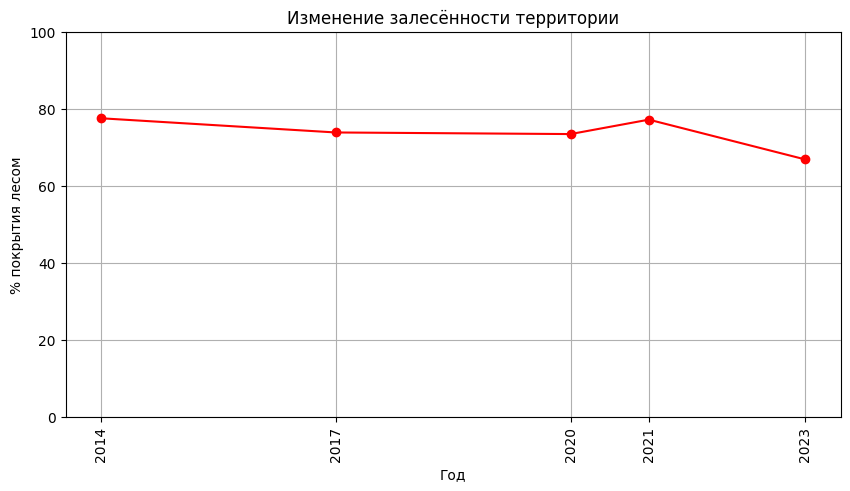

In [ ]:
# Данные в виде словаря {год: значение NDVI}
data = {1990: 18.44, 1995: 47.79, 1999: 52.83, 2005: 58.96, 2010: 60.335, 2014: 77.49, 2017: 73.80, 2020: 73.385, 2021: 77.13, 2023: 66.78333333}

# Преобразуем данные в DataFrame
df = pd.DataFrame(list(data.items()), columns=['Year', 'NDVI'])

# Создаем график
plt.figure(figsize=(10, 5))
plt.plot(df['Year'], df['NDVI'], marker='o', color='r', linestyle='-')

# Настройки осей
plt.xlabel('Год')
plt.ylabel('% покрытия лесом')
plt.title('Изменение залесённости территории')
plt.xticks(df['Year'], rotation=90)

# Устанавливаем минимальное и максимальное значение для оси Y
plt.ylim(0, 100)

# Отображаем график
plt.grid(True)
plt.show()

# Сравнение двух цветовых схем и отображение на них террторий, которые ранее были без деревьев, а сейчас покрыты лесом и наоборот

In [ ]:
# Создаем третью матрицу на основе условий
matrix3 = np.zeros_like(matrix_1990)

for i in range(matrix_1990.shape[0]):
    for j in range(matrix_1990.shape[1]):
        if matrix_1990[i,j] == 0 and matrix_2023[i,j] == 1:
            matrix3[i,j] = 3 # На первой схеме - красный пиксель, на второй - зелёный
        elif matrix_1990[i,j] == 2 and matrix_2023[i,j] == 2:
            matrix3[i,j] = 2
        elif matrix_1990[i,j] == 1 and matrix_2023[i,j] == 0:
            matrix3[i,j] = 4 # На первой схеме - зелёный пиксель, на второй - красный
        elif matrix_1990[i,j] == 0 and matrix_2023[i,j] == 0:
            matrix3[i,j] = 0
        elif matrix_1990[i,j] == 1 and matrix_2023[i,j] == 1:
            matrix3[i,j] = 1

print(matrix3)

[[2. 2. 2. ... 2. 2. 2.]
 [2. 2. 2. ... 2. 2. 2.]
 [2. 2. 2. ... 2. 2. 2.]
 ...
 [2. 2. 2. ... 2. 2. 2.]
 [2. 2. 2. ... 2. 2. 2.]
 [2. 2. 2. ... 2. 2. 2.]]


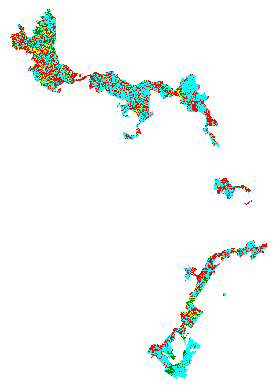

In [ ]:
# Определение цветов для каждого значения в матрице
colors = {0: 'red', 1: 'green', 2: 'white', 3: 'cyan', 4: 'yellow'}

# Составление цветовой карты
color_map = np.vectorize(colors.get)(matrix3)

# Преобразование строковых цветов в числовой формат RGBA
color_map_rgba = np.array([[mcolors.to_rgba(color) for color in row] for row in color_map])

plt.imshow(color_map_rgba, interpolation='nearest')
plt.axis('off')
plt.show()

# Примеры исходное изображение + цветовая схема (территория 1, 5 индексов)





## NDVI

май

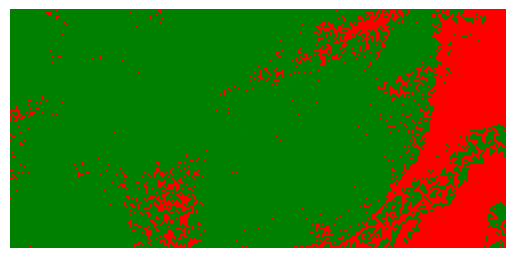

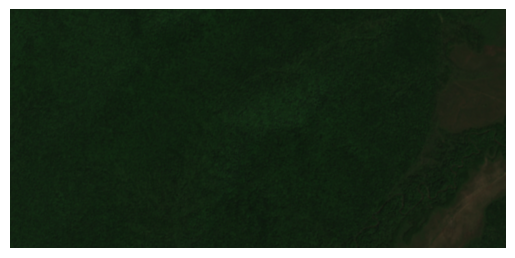

июнь

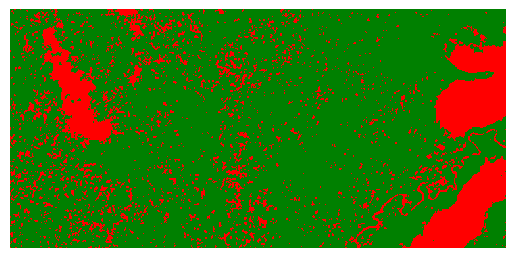

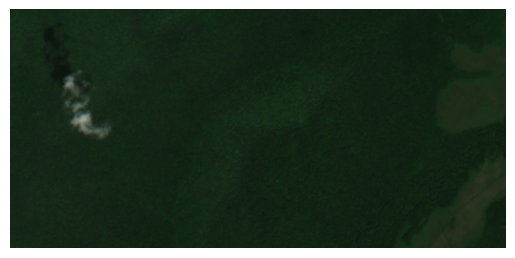

июль

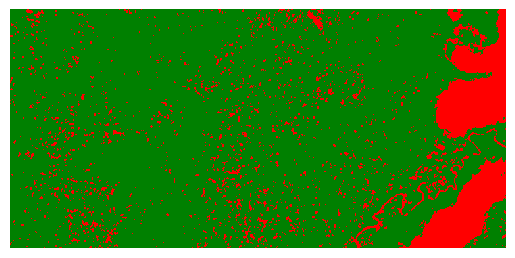

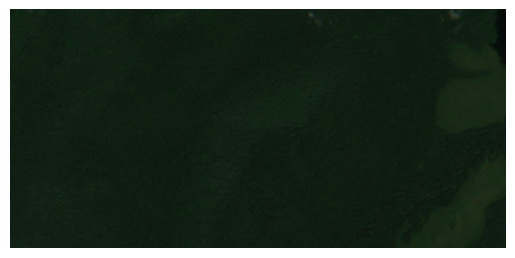

август

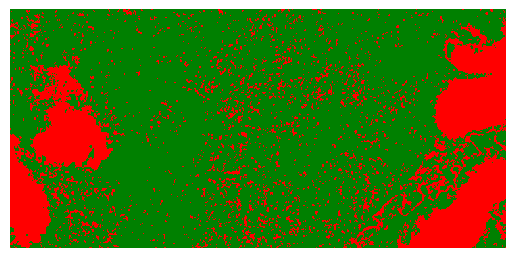

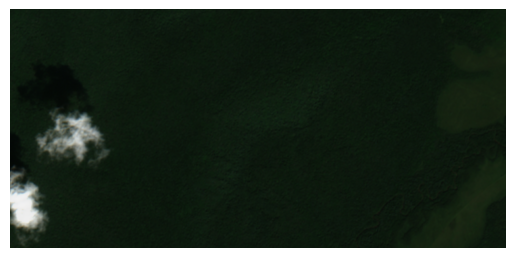

сентябрь

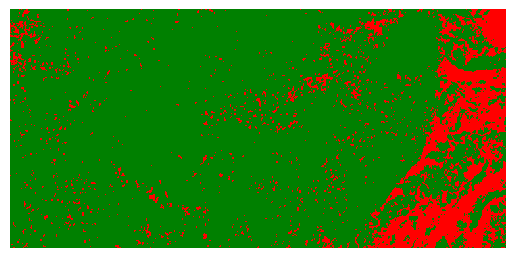

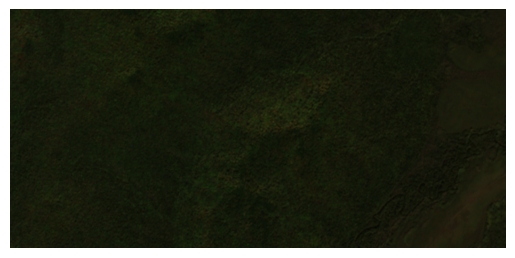

## GNDVI

май

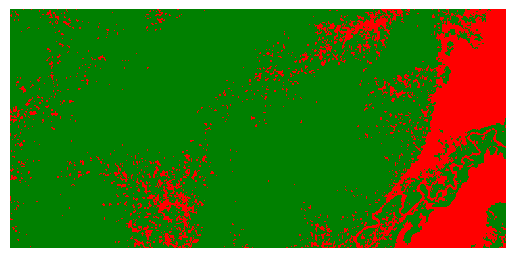

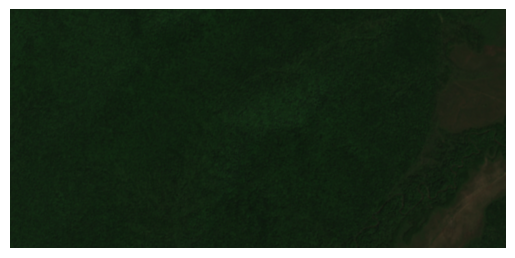

июнь

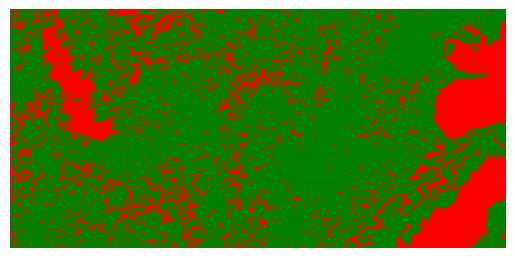

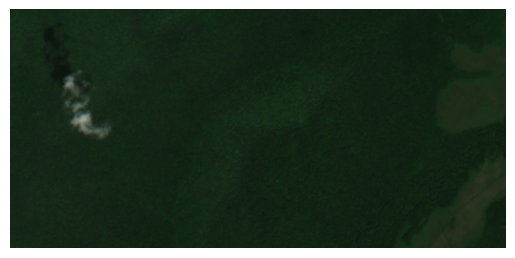

июль

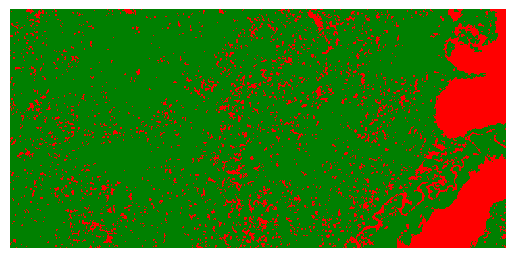

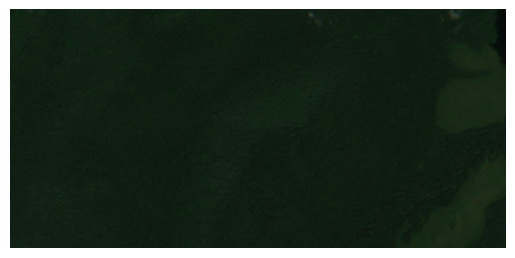

август

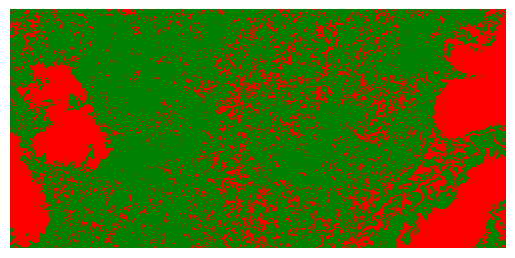

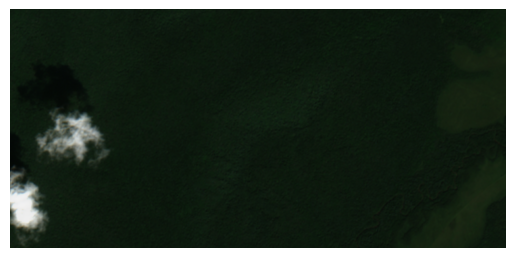

сентябрь

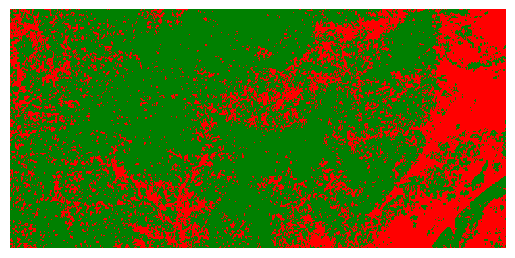

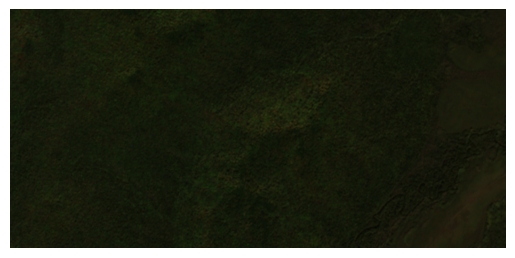

## DVI

май

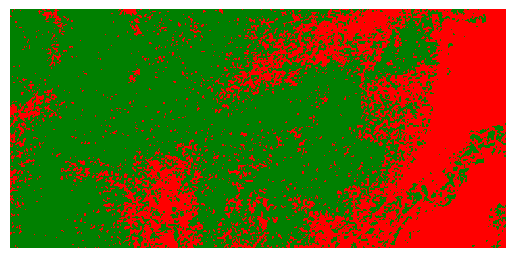

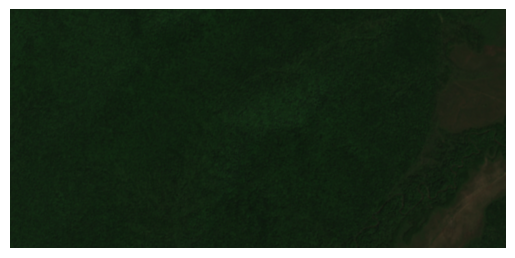

июнь

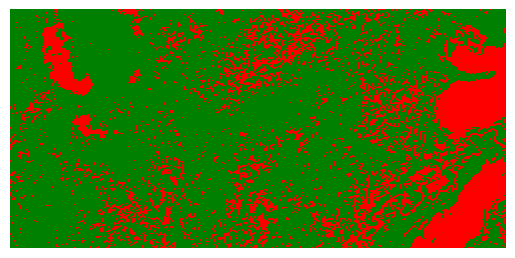

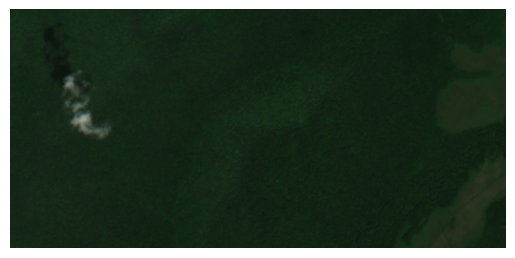

июль

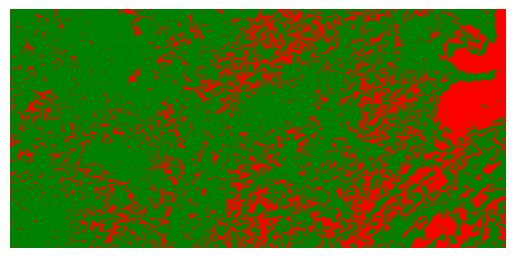

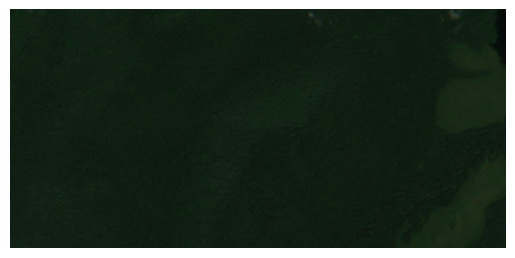

август

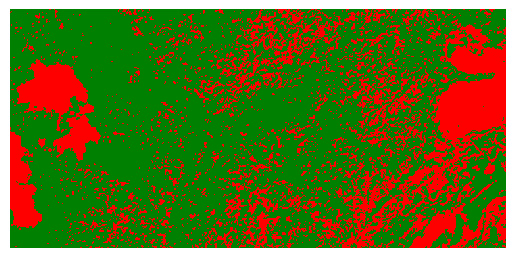

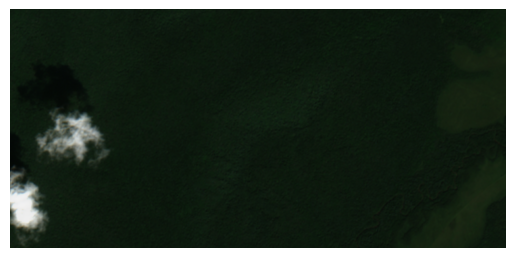

сентябрь

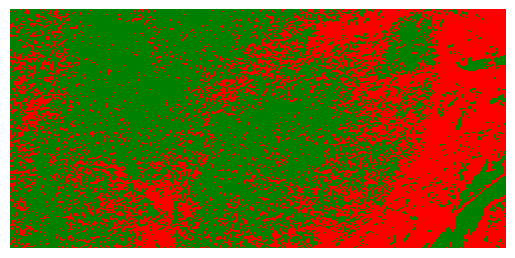

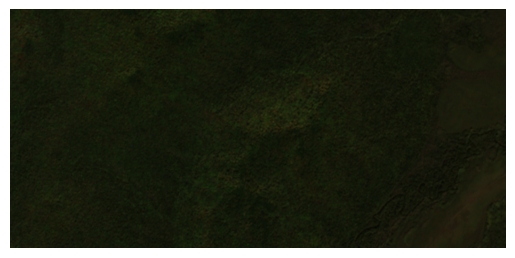

## NDRE

май

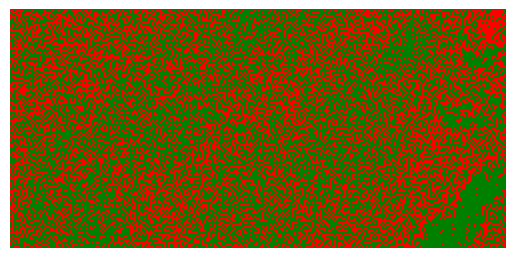

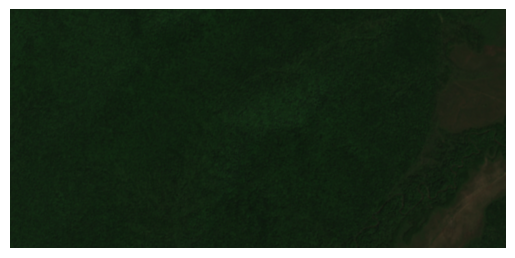

июнь

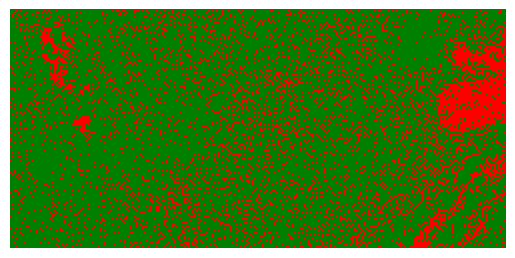

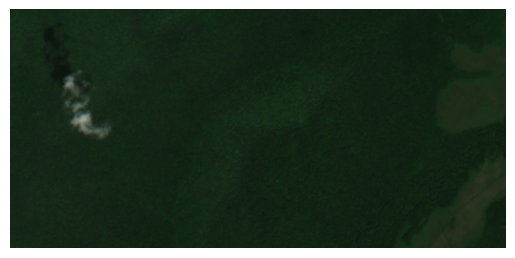

июль

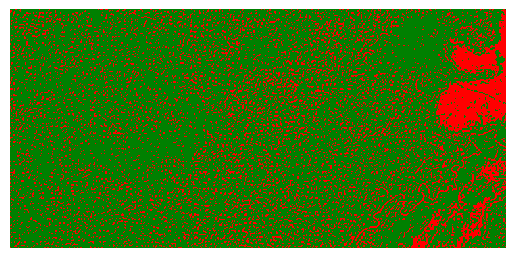

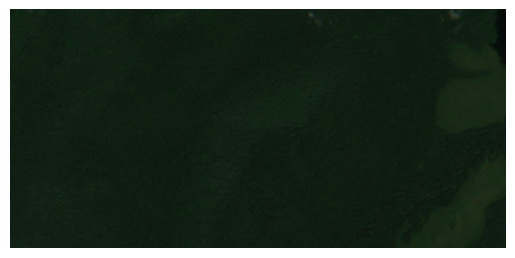

август

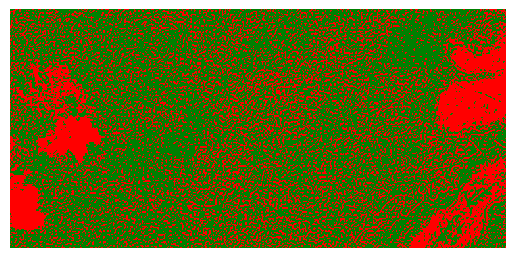

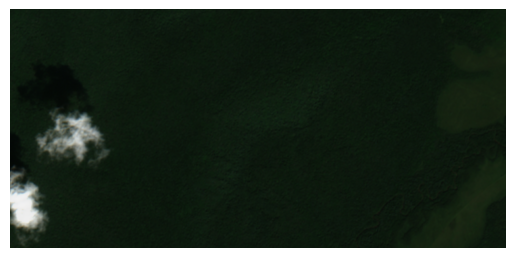

сентябрь

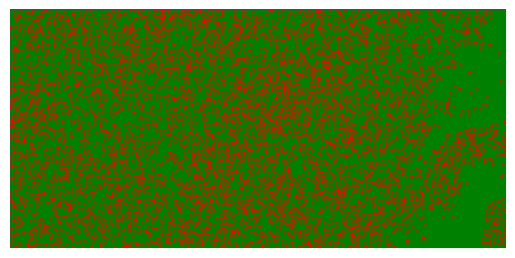

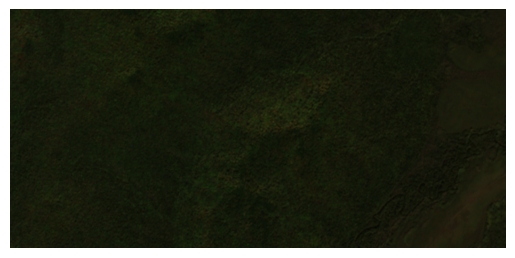

## EVI

май

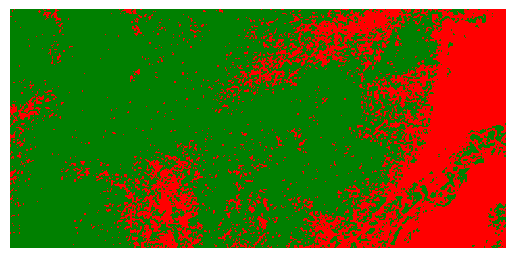

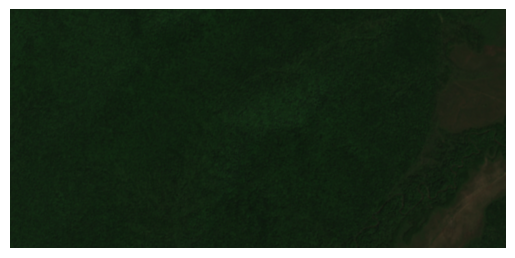

июнь

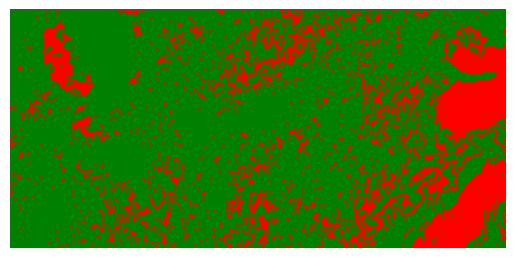

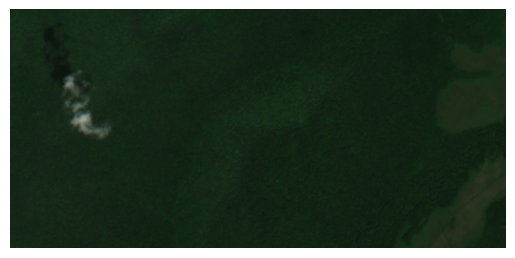

июль

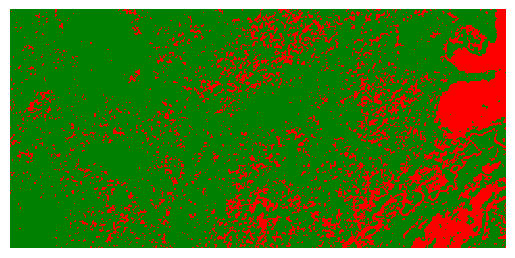

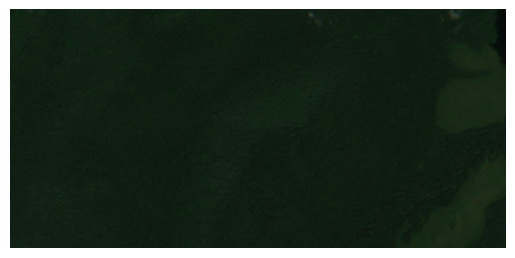

август

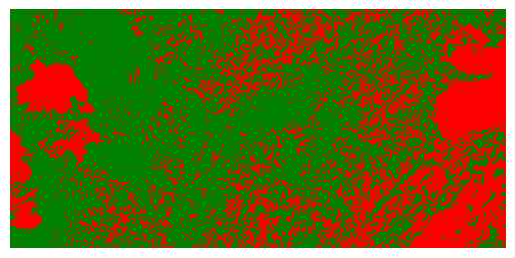

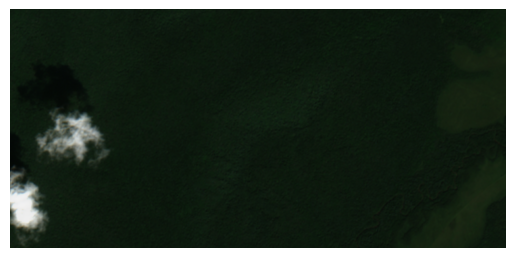

сентябрь

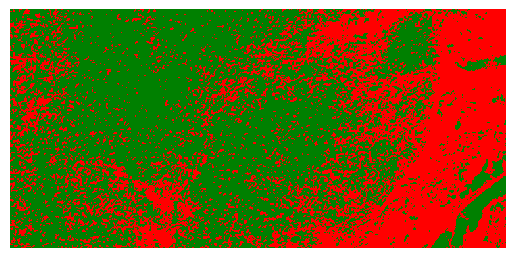

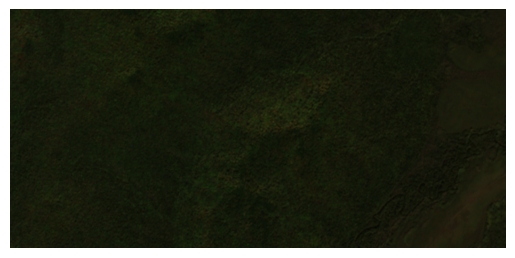
